# VSB Powerline 

tests of different cmap colours and range

using spectrograms created in vsb_powerline_spectrograms

In [189]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [190]:
import datetime
import uuid
from os import listdir
from os.path import isfile, join
import glob

In [191]:
from fastai.vision import *

In [192]:
from fastai import *
from fastai.tabular import *
from fastai.utils import *

In [193]:
import fastai
print(fastai.__version__)

1.0.41.dev0


In [194]:
torch.cuda.set_device(0)

In [195]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]

In [196]:
DATE

'20190120'

In [197]:
UID

'091aa7c1'

In [198]:
MODEL_NAME='300_ts_shift_aug'

In [199]:
image_size=300
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [200]:
path = Path('../input/')

#try 3 types:
#each with and without ts aug
train_path = path/'train_300_ts_aug_viridis-60_10/'
#test_300_ts_aug_viridis-60_10 tt Y ts aug Y

#train_300_ts_aug_viridis-110-20 tt N ts aug Y
#test_300_ts_aug_viridis-110-20 tt N ts aug N -Running 

#train_300_bw-60_10 tt Y ts aug N
#test_300_bw-60_10 tt Y ts aug N

#~used in initial submissions?
#train_300_bw-70_20 'train_300_aug' tt Y ts aug N
#test_300_bw-70_20 'train_300_aug' tt Y ts aug N

In [201]:
test_path = path/'test_300_viridis-60_10/'

In [202]:
train_df = pd.read_csv(path/'metadata_train.csv')

In [203]:
test_df = pd.read_csv(path/'metadata_test.csv')

In [204]:
train_df.tail()

,signal_id,id_measurement,phase,target
8707,8707,2902,1,0
8708,8708,2902,2,0
8709,8709,2903,0,0
8710,8710,2903,1,0
8711,8711,2903,2,0


In [205]:
aug_df = pd.read_csv(path/'metadata_train.csv')

In [206]:
train_files = [f for f in listdir(str(train_path)) if isfile(join(str(train_path), f))]

In [207]:
train_files[:10]

['6430.jpg',
 '6278_neg_aug_875.jpg',
 '5197.jpg',
 '8171.jpg',
 '5284_neg_aug_75.jpg',
 '4413.jpg',
 '709_neg_aug_50.jpg',
 '4913.jpg',
 '3447.jpg',
 '5030.jpg']

In [208]:
aug_sig_names=[]
sigs=[]
for f in train_files:
    f_name=f.split('.jpg')[0]
    if '_' in f_name:
        sigs.append(f_name.split('_')[0])
        aug_sig_names.append(f_name)

In [209]:
len(aug_sig_names)

6300

In [210]:
idms=[]
phases=[]
targets=[]
for f, s in zip(aug_sig_names, sigs):
    row = train_df.loc[train_df['signal_id'] == int(s)]
    assert row is not None
    idms.append(row['id_measurement'].values[0])
    phases.append(row['phase'].values[0])
    targets.append(row['target'].values[0])
    

In [211]:
aug_df = pd.DataFrame([aug_sig_names, idms, phases, targets])

In [212]:
aug_df=aug_df.T


In [213]:
aug_df.columns=['signal_id','id_measurement','phase','target']
aug_df.head()

,signal_id,id_measurement,phase,target
0,6278_neg_aug_875,2092,2,1
1,5284_neg_aug_75,1761,1,1
2,709_neg_aug_50,236,1,1
3,2418_pos_aug_625,806,0,1
4,5983_neg_aug_125,1994,1,1


#### combine into one dataframe

In [214]:
#not for base model - t/t only and cf 70_20, 60-10 and 110-20
#train_df = pd.concat([train_df, aug_df], ignore_index=True)

In [215]:
len(train_df)

8712

In [216]:
train_df['target'].value_counts()

0    8187
1     525
Name: target, dtype: int64

In [217]:
train_df.head(n=2)

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0


### Validation indexes

In [218]:
df_val = train_df.sample(frac=0.2)
val_idxs=df_val.index.values

### Image Data

In [219]:
#set the random seed so that validation indexes are always the same
np.random.seed(42)

In [220]:
#tfms = get_transforms(do_flip=False, max_rotate=0, max_zoom=0, max_lighting=0.0, max_warp=0)

In [221]:
tfms = get_transforms(do_flip=False, 
                      flip_vert=False, 
                      max_rotate=0., 
                      max_zoom=0., 
                      max_lighting=0., 
                      max_warp=0., 
                      p_affine=0., 
                      p_lighting=0.)

In [222]:
train_path

PosixPath('../input/train_300_ts_aug_viridis-60_10')

In [223]:
train_df.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


### using databunch API

train_300_ts_aug_viridis-60_10

In [224]:
data = (ImageItemList.from_df(train_df, path=train_path, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [225]:
#data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg')

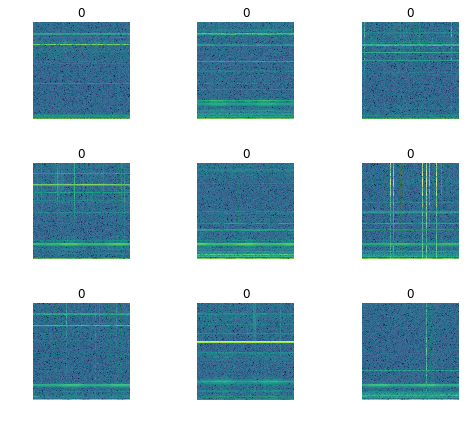

In [226]:
data.show_batch(rows=3, figsize=(7,6))

In [227]:
print(data.classes)
len(data.classes), data.c

[0, 1]


(2, 2)

## Training: resnet34

In [228]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [229]:

#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

In [230]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


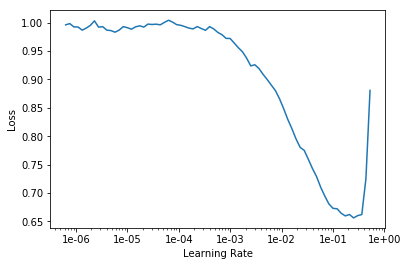

In [231]:
learn.recorder.plot()

#### Fit

In [232]:
#0.052115 	0.087694 	0.035591 #cf 5 epochs; default lr; submission 2

'''train_300_ts_aug_viridis-60_10
epoch 	train_loss 	valid_loss 	error_rate
1 	0.294124 	0.249195 	0.099933
2 	0.196477 	0.155289 	0.060626
3 	0.147138 	0.131121 	0.048634
4 	0.099223 	0.072519 	0.025316
5 	0.056315 	0.059300 	0.018987
'''
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,error_rate
1,0.221634,0.165752,0.043628
2,0.176443,0.241365,0.081515
3,0.133526,0.148563,0.066016
4,0.097695,0.079477,0.035591
5,0.070790,0.069917,0.029277


In [233]:
#### cf this cmap

In [234]:
train_path = path/'train_300_bw-60_10/'

In [235]:
test_path = path/'test_300_bw-60_10/'

In [236]:
data = (ImageItemList.from_df(train_df, path=train_path, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [237]:
#data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg')

In [238]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [239]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


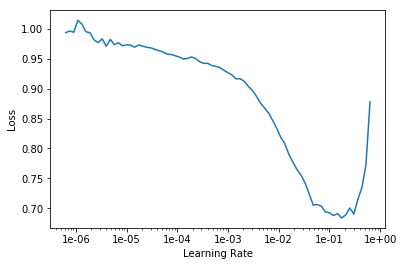

In [240]:
learn.lr_find()
learn.recorder.plot()

In [241]:
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,error_rate
1,0.250391,0.124453,0.044202
2,0.171824,0.099574,0.039036
3,0.134386,0.099797,0.037887
4,0.091068,0.105230,0.042480
5,0.065701,0.072388,0.027555


In [242]:
#### cf train . test

In [243]:
train_path = path/'train/'

In [244]:
test_path = path/'test/'

In [245]:
data = (ImageItemList.from_df(train_df, path=train_path, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [246]:
#data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg')

In [247]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [248]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


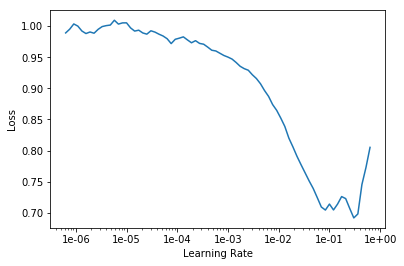

In [249]:
learn.lr_find()
learn.recorder.plot()

In [250]:
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,error_rate
1,0.256177,0.303034,0.081515
2,0.163576,0.090122,0.035017
3,0.131578,0.158129,0.041332
4,0.099136,0.085639,0.033295
5,0.064370,0.066672,0.024110


In [251]:
#### test_300_bw-70_20

In [252]:
train_path = path/'train_300_bw-70_20'

In [253]:
test_path = path/'test_300_bw-70_20'

In [254]:
data = (ImageItemList.from_df(train_df, path=train_path, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [255]:
#data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg')

In [256]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [257]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


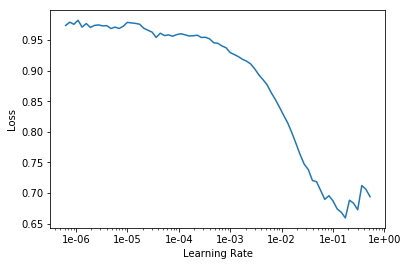

In [258]:
learn.lr_find()
learn.recorder.plot()

In [259]:
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,error_rate
1,0.250480,0.237734,0.092423
2,0.178192,0.165642,0.065442
3,0.130880,0.155803,0.057405
4,0.092384,0.107337,0.046498
5,0.052800,0.065332,0.026406


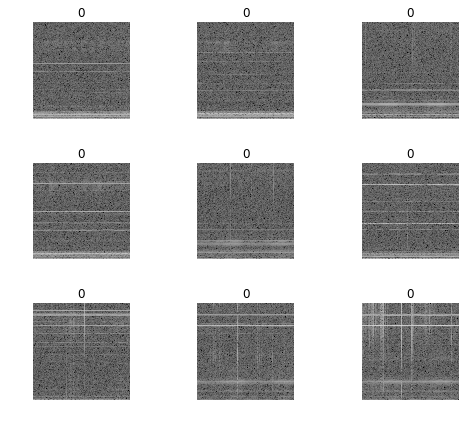

In [260]:
data.show_batch(rows=3, figsize=(7,6))

In [261]:
#### test_300_ts_aug_bw-110-20

In [262]:
train_path = path/'train_300_ts_aug_bw-110-20'

In [263]:
test_path = path/'test_300_ts_aug_bw-110-20'

In [264]:
data = (ImageItemList.from_df(train_df, path=train_path, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [265]:
#data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg')

In [266]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [267]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


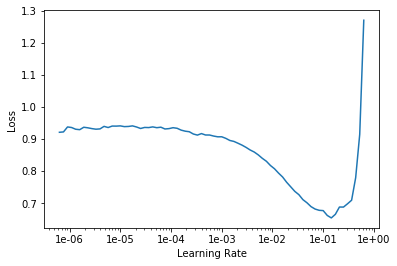

In [268]:
learn.lr_find()
learn.recorder.plot()

In [269]:
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,error_rate
1,0.230063,0.881872,0.380597
2,0.164280,0.136247,0.051665
3,0.125059,0.097662,0.037313
4,0.090719,0.074353,0.025258
5,0.062807,0.068969,0.025258


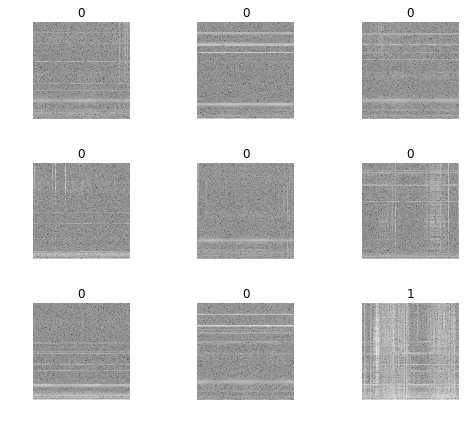

In [270]:
data.show_batch(rows=3, figsize=(7,6))

In [271]:
#### cf viridis-110-20

In [272]:
train_path = path/'train_300_ts_viridis-110-20/'

In [273]:
data = (ImageItemList.from_df(train_df, path=train_path, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [274]:
#data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg')

In [275]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [276]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


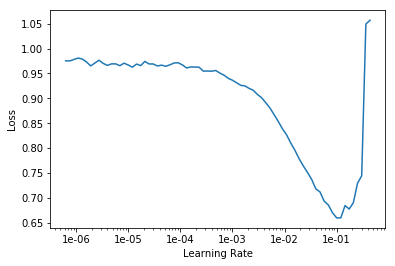

In [277]:
learn.lr_find()
learn.recorder.plot()

In [278]:
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,error_rate
1,0.235914,0.213423,0.058553
2,0.171685,0.088021,0.034443
3,0.125712,0.092297,0.041332
4,0.099533,0.084565,0.036739
5,0.068508,0.075196,0.033295


#### cf train_300_bp_500Hz-40MHz

Poor result for bp data, leave out

In [279]:
train_path = path/'train_300_bp_500Hz-40MHz/'

In [280]:
test_path = path/'test_300_bp_500Hz-40MHz/'

In [281]:
data = (ImageItemList.from_df(train_df, path=train_path, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [282]:
#data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg')

In [283]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [284]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


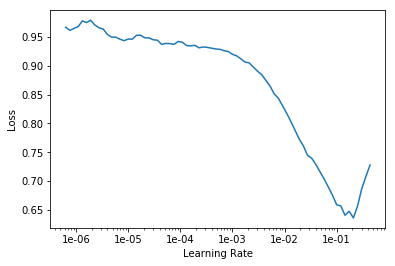

In [285]:
learn.lr_find()
learn.recorder.plot()

In [286]:
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,error_rate
1,0.242603,0.322788,0.144087
2,0.198989,0.113234,0.040184
3,0.136512,0.114040,0.046498
4,0.106125,0.090635,0.035017
5,0.072208,0.074810,0.024110


### Tabulation of experiment results

![title](results/cmap_performance.png)

And average Loss vs Variance

![title](results/loss_vs_variance.png)

Best colourmapss and ranges overall: viridis -60 to 10, viridis -110 to 20, gray -60-10, viridis -70 to 20

### running code below from datascience env


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GASF, GADF

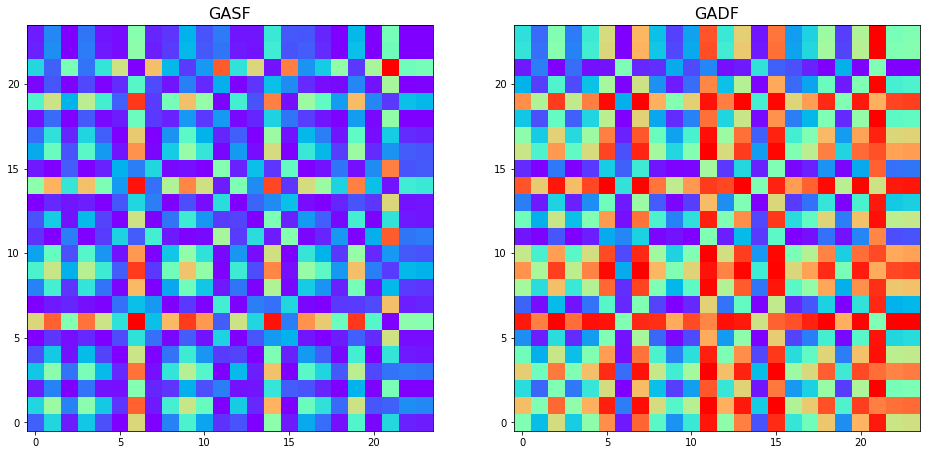

In [2]:


# Parameters
n_samples, n_features = 100, 144

# Toy dataset
rng = np.random.RandomState(41)
X = rng.randn(n_samples, n_features)

# GAF transformations
image_size = 24
gasf = GASF(image_size)
X_gasf = gasf.fit_transform(X)
gadf = GADF(image_size)
X_gadf = gadf.fit_transform(X)

# Show the results for the first time series
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(X_gasf[0], cmap='rainbow', origin='lower')
plt.title("GASF", fontsize=16)
plt.subplot(122)
plt.imshow(X_gadf[0], cmap='rainbow', origin='lower')
plt.title("GADF", fontsize=16)
plt.show()

In [3]:
# Parameters
n_samples, n_features = 800000, 800

# Toy dataset
rng = np.random.RandomState(41)
X = rng.randn(n_samples, n_features)

# GAF transformations
image_size = 300
gasf = GASF(image_size)
X_gasf = gasf.fit_transform(X)
gadf = GADF(image_size)
X_gadf = gadf.fit_transform(X)

# Show the results for the first time series
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(X_gasf[0], cmap='rainbow', origin='lower')
plt.title("GASF", fontsize=16)
plt.subplot(122)
plt.imshow(X_gadf[0], cmap='rainbow', origin='lower')
plt.title("GADF", fontsize=16)
plt.show()

MemoryError: 